In [1]:
# imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# Helper Functions

In [2]:
def clean_dir(path):
    """Makes a clean directory, removes all files and folders in the specified path"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")    

# Gather the Data
First step is to gather the data. There is a module defined called RetroSheetDownloader with a class called DownloadRetroSheetData. Using the class, call the run method that will download the data in .txt format.

In [3]:
from RetroSheetDownloader import DownloadRetroSheetData

# Create an instance of the class and calls the run method. By default, we download the data from the years 2014 to 2019, inclusive 
DownloadRetroSheetData().run()

Unzipping gl2019.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.77log/s]


Next, let's try opening the data with pandas so we can see it in tabular form.

In [4]:
import pandas as pd
import os

RETROSHEET_FILES = "./datasets/retro_sheet_gls"

# We will be looking at the 2014 data as an example
retro_sheet_data_gl2014 = pd.read_csv("./datasets/retro_sheet_gls/GL2014.TXT")

# Get all the games that the Yankees played in 2014
nya_gl_2014 = retro_sheet_data_gl2014.loc[(retro_sheet_data_gl2014["Home Team"] == 'NYA') | 
                                          (retro_sheet_data_gl2014["Visiting Team"] == 'NYA')]

# Sort the games played by date
display(nya_gl_2014.sort_values("Date"))

,Date,Number of game,Day,Visiting Team,Visiting Team League,Visiting Team Game Number,Home Team,Home Team League,Home Team Game Number,Visiting Team Score,...,Home Team Player 7 Name,Home Team Player 7 Defensive Position,Home Team Player 8 ID,Home Team Player 8 Name,Home Team Player 8 Defensive Position,Home Team Player 9 ID,Home Team Player 9 Name,Home Team Player 9 Defensive Position,Miscellaneous,Acquisition Information
17,20140401,0,Tue,NYA,AL,1,HOU,AL,1,2,...,Matt Dominguez,5,hoesl001,L.J. Hoes,9,villj001,Jonathan Villar,6,NaN,Y
28,20140402,0,Wed,NYA,AL,2,HOU,AL,2,1,...,Matt Dominguez,5,presa001,Alex Presley,9,villj001,Jonathan Villar,6,NaN,Y
42,20140403,0,Thu,NYA,AL,3,HOU,AL,3,4,...,Matt Dominguez,5,presa001,Alex Presley,9,villj001,Jonathan Villar,6,NaN,Y
56,20140404,0,Fri,NYA,AL,4,TOR,AL,5,7,...,Brett Lawrie,5,goinr001,Ryan Goins,4,diazj004,Jonathan Diaz,6,NaN,Y
71,20140405,0,Sat,NYA,AL,5,TOR,AL,6,0,...,Josh Thole,2,goinr001,Ryan Goins,4,diazj004,Jonathan Diaz,6,NaN,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,20140924,0,Wed,BAL,AL,158,NYA,AL,158,9,...,Chris Young,7,richa001,Antoan Richardson,9,ryanb002,Brendan Ryan,6,NaN,Y
2375,20140925,0,Thu,BAL,AL,159,NYA,AL,159,5,...,Stephen Drew,4,suzui001,Ichiro Suzuki,9,pirej001,Jose Pirela,10,NaN,Y
2384,20140926,0,Fri,NYA,AL,160,BOS,AL,160,3,...,Bryce Brentz,7,lavar001,Ryan Lavarnway,3,butld001,Dan Butler,2,NaN,Y
2400,20140927,0,Sat,NYA,AL,161,BOS,AL,161,4,...,Rusney Castillo,8,brenb002,Bryce Brentz,7,vazqc001,Christian Vazquez,2,NaN,Y


Using this idea we can generate the starting lineup for each team for each season's game logs that we download. Let's first get all of the teams in the league. We can keep a set of the team abbreviations. We can then loop through all of the game log files we got from *retrosheet* and for each team, make a dataframe that has all of games for one particular team.

In [5]:
# We will store the games played by each team here
TEAM_GAMES = "./datasets/games_by_teams/"

# There should be 30 teams in the MLB
teams = set(retro_sheet_data_gl2014["Home Team"])
assert len(teams) == 30

def generate_all_games_per_team(all_game_per_season, all_games_per_team_dir, teams):
    """For each team, generate the games that they have played over the course of the years"""
    
    if not os.path.exists(all_games_per_team_dir):
        os.mkdir(all_games_per_team_dir)
    
    # Delete the files that are in the folder already just in case
    for f in os.listdir(all_games_per_team_dir):
        os.remove(os.path.join(all_games_per_team_dir, f))

    with tqdm(total=len(teams), unit="teams") as pbar:
        for team in teams:
            pbar.set_description(team)
            team_dfs = list()
            for file in os.listdir(all_game_per_season):
                file_name = os.path.join(all_game_per_season, file)
                gl_year = pd.read_csv(file_name)

                # Get the tables for the team's home and away games
                team_gl_year = gl_year.loc[(gl_year["Home Team"] == team) |
                                            (gl_year["Visiting Team"] == team)]

                # Add the concatenated dataframe to the placeholder list
                team_dfs.append(team_gl_year)

            # Concatenate all of the intermediate 
            team_all_games = pd.concat(team_dfs).sort_values("Date")
            team_all_games.to_csv(os.path.join(all_games_per_team_dir, f"{team}_all_games.csv"), index=None)
            pbar.update()

In [6]:
generate_all_games_per_team(RETROSHEET_FILES, TEAM_GAMES,teams)

ATL: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.11teams/s]


Let's quickly look at an arbitrary csv file we just generated and make sure that there are 30 new files generated.

In [7]:
# Load Tampa Bay Rays as an example
tba_gl_all = pd.read_csv(os.path.join(TEAM_GAMES, "TBA_all_games.csv"))

# There are 162 games per season and the number of seasons that we have are the number of
# retrosheet files that we downloaded
assert tba_gl_all.shape[0] == 162 * len([f for f in os.listdir(RETROSHEET_FILES)])

display(tba_gl_all)

,Date,Number of game,Day,Visiting Team,Visiting Team League,Visiting Team Game Number,Home Team,Home Team League,Home Team Game Number,Visiting Team Score,...,Home Team Player 7 Name,Home Team Player 7 Defensive Position,Home Team Player 8 ID,Home Team Player 8 Name,Home Team Player 8 Defensive Position,Home Team Player 9 ID,Home Team Player 9 Name,Home Team Player 9 Defensive Position,Miscellaneous,Acquisition Information
0,20140331,0,Mon,TOR,AL,1,TBA,AL,1,2,...,Matt Joyce,10,molij001,Jose Molina,2,escoy001,Yunel Escobar,6,NaN,Y
1,20140401,0,Tue,TOR,AL,2,TBA,AL,2,4,...,Logan Forsythe,10,hanir001,Ryan Hanigan,2,escoy001,Yunel Escobar,6,NaN,Y
2,20140402,0,Wed,TOR,AL,3,TBA,AL,3,3,...,Sean Rodriguez,7,molij001,Jose Molina,2,escoy001,Yunel Escobar,6,NaN,Y
3,20140403,0,Thu,TOR,AL,4,TBA,AL,4,2,...,Matt Joyce,9,hanir001,Ryan Hanigan,2,escoy001,Yunel Escobar,6,NaN,Y
4,20140404,0,Fri,TEX,AL,4,TBA,AL,5,1,...,Brandon Guyer,7,hanir001,Ryan Hanigan,2,escoy001,Yunel Escobar,6,NaN,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,20190924,0,Tue,NYA,AL,158,TBA,AL,158,1,...,Joey Wendle,4,adamw002,Willy Adames,6,kierk001,Kevin Kiermaier,8,NaN,Y
968,20190925,0,Wed,NYA,AL,159,TBA,AL,159,0,...,Matt Duffy,5,kierk001,Kevin Kiermaier,8,adamw002,Willy Adames,6,NaN,Y
969,20190927,0,Fri,TBA,AL,160,TOR,AL,160,6,...,Teoscar Hernandez,8,urenr001,Richard Urena,6,fishd001,Derek Fisher,7,NaN,Y
970,20190928,0,Sat,TBA,AL,161,TOR,AL,161,1,...,Anthony Alford,7,jansd001,Danny Jansen,2,urenr001,Richard Urena,6,NaN,Y


# Preliminary Observations

## Does Being the Home Team Matter?

Alright, so at this point we might be able to look at couple of things that might indicate as being good labels to use in our models. One thing we might look at is how often home teams win their games. It's thought to be true that there is an inherent advantage of teams playing in front of their own fans. Let's see if there is any correlation. If being the home team matters, then the number of home games won over the number of total games won should be over 50%.

In [8]:
def win_percentage_of_home_games(games_dir):
    """Function which returns the percentage of games won by the home team"""
    
    df_list = []
    for file in os.listdir(games_dir):
        df_list.append(pd.read_csv(os.path.join(games_dir, file)))
    all_games = pd.concat(df_list)
    home_game_wins = all_games.loc[all_games["Home Team Score"] > all_games["Visiting Team Score"]].shape[0]
    return home_game_wins/all_games.shape[0]

In [9]:
win_percentage_of_home_games(RETROSHEET_FILES)

0.5331000891815875

As we can see, out of all the games played, the home team only won 53% of the time, meaning that there doesn't seem to be an inherit advantage for the home team. This is honestly lower than we expected and are quite surprised with the result. There are a few things to note here however. This percentage is based on the whole league. It might be smarter to look at the number of games won at home out of the total games won **per team**

In [10]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


def won_home_games_over_won_games_by_team(all_games_per_team, teams):
    """Function to plot home wins over total wins by team"""
    
    # create x and y
    x = sorted(teams)
    percentages = []
    
    # Get percentages for each team
    for team in x:
        csv_path = os.path.join(all_games_per_team, f"{team}_all_games.csv")
        df = pd.read_csv(csv_path)
        wins = df.loc[((df["Home Team"] == team) & (df["Home Team Score"] > df["Visiting Team Score"])) |
                     ((df["Visiting Team"] == team) & (df["Home Team Score"] < df["Visiting Team Score"]))]
        number_wins = wins.shape[0]
        number_home_wins = wins.loc[wins["Home Team"] == team].shape[0]
        percentages.append(number_home_wins/number_wins)
    
    # Plot the data
    plt.figure(figsize=(20,7))
    
    x_pos = [i for i, _ in enumerate(teams)]
    
    plt.bar(x_pos, percentages, color=(.48, .69, .53, 0.6))
    plt.xlabel("Teams")
    plt.ylabel("Percentage of Home Games Won out of Total Games Wons")
    plt.title("Percentage of Home Games Won out of Total Games Won", fontsize=14)
    plt.plot(range(-1, 31), [.5]*32, "r--")
    
    plt.xticks(x_pos, x)
    plt.show()
    plt.close()

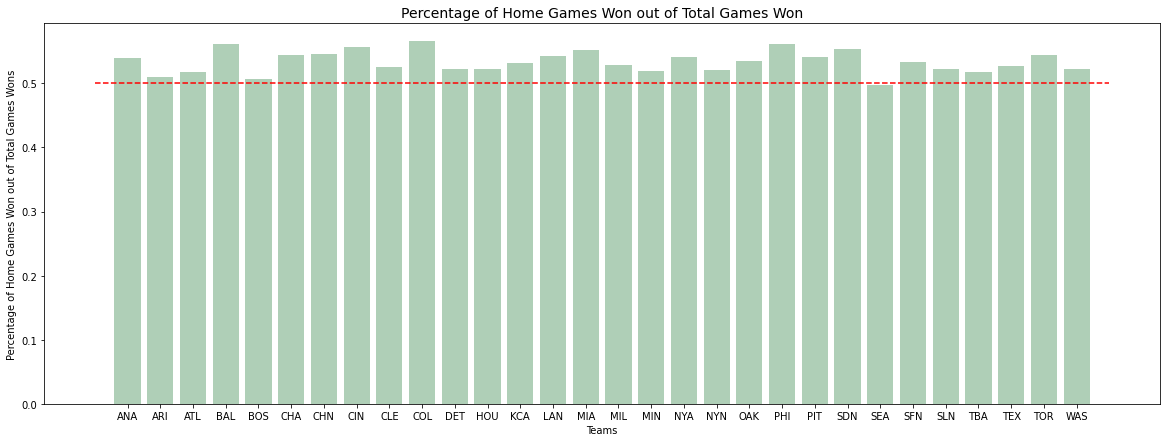

In [11]:
won_home_games_over_won_games_by_team(TEAM_GAMES, list(teams))

This plot shows that out of all of the wins a team may have, slightly more than half of them are won at home. In fact, the Seattle Mariners, from 2014-2019, won more of their games as the visting team! This further strengthens the idea that the home team only has a slight advantage compared to the away team, if any at all.

## Number of Runs Scored vs. Wins

Naturally a more potent offense should win more games. And generally, a better offense will score more runs. We should see whether or not a team that scores more runs will win more games

# Getting the Data Ready for Training and Testing

Ideally, we want to have the model be trained on the data that contains the relevant stats on each of the players. We will try and implement this later. Let's look to see if we can make a model just using the Retrosheet game logs.

In [12]:
import pandas as pd
import os

# Get all the gamelogs in on dataframe
game_logs = [pd.read_csv(os.path.join(RETROSHEET_FILES, i)) for i in os.listdir(RETROSHEET_FILES)]
games = pd.concat(game_logs)
labels_to_keep = [
    "Date",
    "Number of game",
    "Visiting Team",
    "Visiting Team League",
    "Visiting Team Game Number",
    "Home Team",
    "Home Team League",
    "Home Team Game Number",
    "Visiting Team Score",
    "Home Team Score",
    "Visiting Team At-bats",
    "Visiting Team Hits",
    "Visiting Team Doubles",
    "Visiting Team Triples",
    "Visiting Team Homeruns",
    "Visiting Team RBIs",
    "Visiting Team Sacrifice Hits",
    "Visiting Team Sacrifice Flies",
    "Visiting Team Hit-by-pitch",
    "Visiting Team Walks",
    "Visiting Team Intentional Walks",
    "Visiting Team Strikeouts",
    "Visiting Team Stolen Bases",
    "Visiting Team Caught Stealing",
    "Visiting Team Grounded into DP",
    "Visiting Team Left on Base",
    "Visiting Team Pitchers Used",
    "Visiting Team Individual Earned Runs",
    "Visiting Team Earned Runs",
    "Visiting Team Wild Pitches",
    "Visiting Team Balks",
    "Visiting Team Putouts",
    "Visiting Team Assists",
    "Visiting Team Errors",
    "Visiting Team Passed Balls",
    "Visiting Team Double Plays",
    "Visiting Team Triple Plays",
    "Home Team At-bats",
    "Home Team Hits",
    "Home Team Doubles",
    "Home Team Triples",
    "Home Team Homeruns",
    "Home Team RBIs",
    "Home Team Sacrifice Hits",
    "Home Team Sacrifice Flies",
    "Home Team Hit-by-pitch",
    "Home Team Walks",
    "Home Team Intentional Walks",
    "Home Team Strikeouts",
    "Home Team Stolen Bases",
    "Home Team Caught Stealing",
    "Home Team Grounded into DP",
    "Home Team Left on Base",
    "Home Team Pitchers Used",
    "Home Team Individual Earned Runs",
    "Home Team Earned Runs",
    "Home Team Wild Pitches",
    "Home Team Balks",
    "Home Team Putouts",
    "Home Team Assists",
    "Home Team Errors",
    "Home Team Passed Balls",
    "Home Team Double Plays",
    "Home Team Triple Plays",
]
games = games.filter(labels_to_keep)

Next, we should add a a label that clearly tells us who the winner is of a certain game. We will create a function that can do this for us.

In [13]:
def label_winner(row):
    if row["Home Team Score"] > row["Visiting Team Score"]:
        return "Home Team"
    else:
        return "Visiting Team"

games["Winner"] = games.apply(lambda row: label_winner(row), axis=1)

We want to compute the moving averages of certain fields. We will expand this to cover exponential moving averages later. Each row should contain the average of their respective fields for the last 14 days. To do this, we will make functions like we did above. We are going to this by team.

One thing that might help is if we create csvs that only have the stats of one team. This will help finding the averages so we don't have to differentiate between home and away teams. We already have all the games for each team. We can get all the home games and visiting games separately. Then we will drop the rows that don't pertain to each team. So if we are getting all the stats for the Angels, and they are the home team for a particular game, we don't need the visiting team rows.

In [14]:
import re

new_labels = [
    "Date",
    "Number of game",
    "Team",
    "League",
    "Game Number",
    "Score",
    "At-bats",
    "Hits",
    "Doubles",
    "Triples",
    "Homeruns",
    "RBIs",
    "Sacrifice Hits",
    "Sacrifice Flies",
    "Hit-by-pitch",
    "Walks",
    "Intentional Walks",
    "Strikeouts",
    "Stolen Bases",
    "Caught Stealing",
    "Grounded into DP",
    "Left on Base",
    "Pitchers Used",
    "Individual Earned Runs",
    "Earned Runs",
    "Wild Pitches",
    "Balks",
    "Putouts",
    "Assists",
    "Errors",
    "Passed Balls",
    "Double Plays",
    "Triple Plays"
]

TEAM_STATS = "./datasets/team_stats"

def one_team_stats(teams, team_gls_path, dest_path):
    """Create CSVS for just one team's stats"""
    
    clean_dir(dest_path)
    with tqdm(total=len(teams), unit="teams") as pbar:
        for team in teams:
            pbar.set_description(team)
            # Read in all the games for the team and filter out unnecessary columns
            team_games = pd.read_csv(os.path.join(team_gls_path, f"{team}_all_games.csv"))
            team_games = team_games.filter(labels_to_keep)
            
            # Get the home games, drop the visiting columns, and rename the columns
            home_games = team_games.loc[team_games["Home Team"] == team].copy()
            home_games.drop(home_games.filter(regex="Visiting ").columns, axis=1, inplace=True)
            home_games.columns = new_labels

            # Get the visiting games, drop the home columns, and rename the columns
            away_games = team_games.loc[team_games["Visiting Team"] == team].copy()
            away_games.drop(away_games.filter(regex="Home ").columns, axis=1, inplace=True)
            away_games.columns = new_labels
            
            # Join the two tables
            team_stats = pd.concat([home_games, away_games])
            team_stats.sort_values(by=["Date", "Number of game"])
            
            team_stats.to_csv(os.path.join(dest_path, f"{team}_stats.csv"), index=None)
            pbar.update()

one_team_stats(teams, TEAM_GAMES, TEAM_STATS)

ATL: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.72teams/s]


Now we have the stats per game per team, now we can compute the exponential moving average for each stat

In [15]:
def compute_ma(span, teams, team_stats_path, dest_path):
    """Computes various moving averages for the stats"""
    
    # Clean directory we will be saving the CSVs to
    clean_dir(AVERAGES)
    
    with tqdm(total=len(teams), unit="teams") as pbar:
        # Loop through the teams
        for team in teams:
            pbar.set_description(team)
            averages = pd.DataFrame()
            
            # Load the stats for a given team
            team_stats = pd.read_csv(os.path.join(team_stats_path, f"{team}_stats.csv"))
            
            # Compute the moving averages for the appropriate columns
            for col in team_stats.columns:
                if col in {"Date", "Number of game", "Team", "League", "Game Number"}:
                    continue
                    
                # We have to shift the average columens down one, this is due to the fact that
                # the current day's stats should not be incldued for the current day's moving
                # averages calculations.
                
                # Simple moving average
                team_stats[f"{col} SMA"] = team_stats.loc[:, col].rolling(window=span).mean()
                team_stats[f"{col} SMA"] = team_stats[f"{col} SMA"].shift(1)
                
                # Cumulative moving average
                team_stats[f"{col} CMA"] = team_stats.loc[:, col].expanding(min_periods=span).mean()
                team_stats[f"{col} CMA"] = team_stats[f"{col} CMA"].shift(1)
                
                # Exponential moving average
                team_stats[f"{col} EMA"] = team_stats.loc[:, col].ewm(span=span, adjust=False).mean()
                team_stats[f"{col} EMA"] = team_stats[f"{col} EMA"].shift(1)
            
            # Drop any rows with NULL values and save the CSV
            team_stats.dropna(inplace=True)
            team_stats.to_csv(os.path.join(dest_path, f"{team}_averages.csv"), index=None)
            pbar.update()

In [16]:
AVERAGES = "./datasets/averages"
compute_ma(10, teams, TEAM_STATS, AVERAGES)

ATL: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.44teams/s]


Let's graph the EMA versus the actual stats. Let's graph the moving averages for Score and Earned Runs for the Yankees

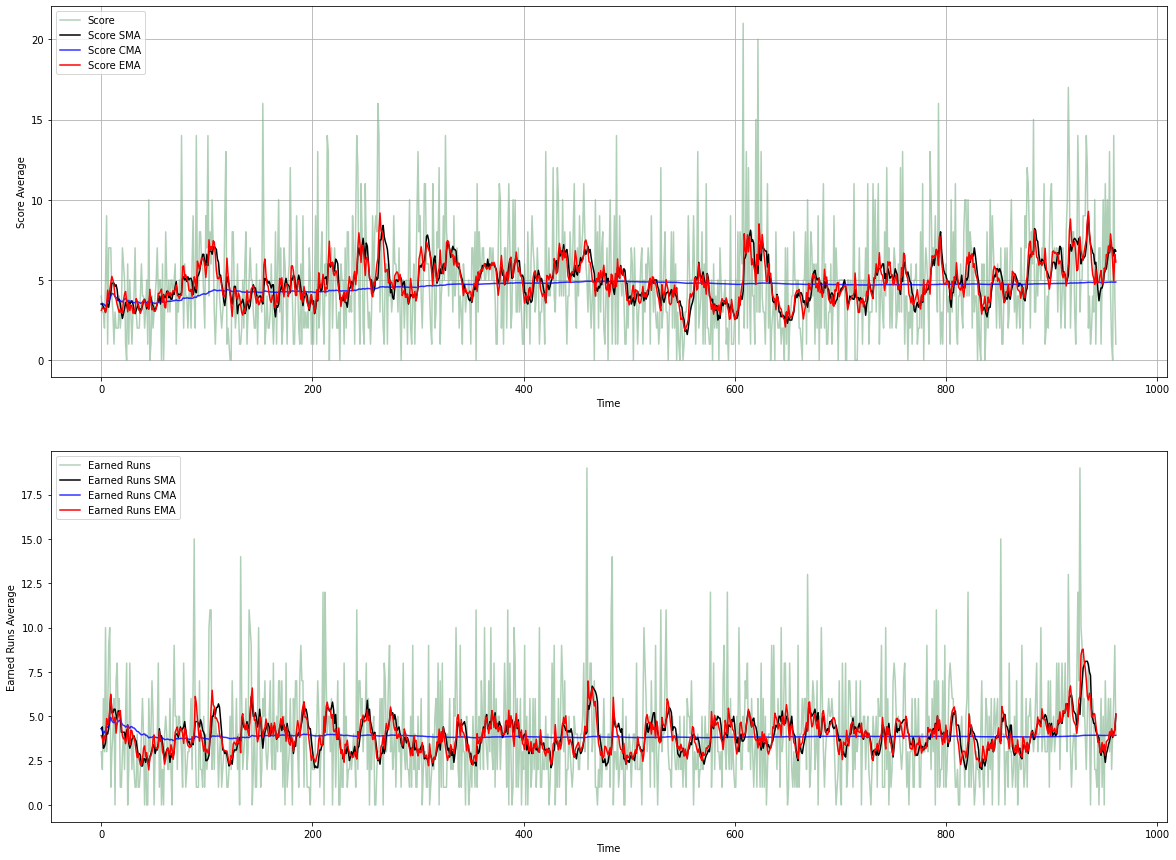

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

nya_averages = pd.read_csv(os.path.join(AVERAGES, "NYA_averages.csv"))
plt.figure(figsize=[20,15])
plt.subplot(211)
plt.grid(True)
plt.plot(nya_averages["Score"], label="Score", color=(.48, .69, .53, 0.6))
plt.plot(nya_averages["Score SMA"], label="Score SMA", color=(0, 0, 0, 1))
plt.plot(nya_averages["Score CMA"], label="Score CMA", color=(0, 0, 1, .8))
plt.plot(nya_averages["Score EMA"], label="Score EMA", color=(1, 0, 0, 1))
plt.xlabel("Time")
plt.ylabel("Score Average")
plt.legend(loc=2)
plt.subplot(212)
plt.plot(nya_averages["Earned Runs"], label="Earned Runs", color=(.48, .69, .53, 0.6))
plt.plot(nya_averages["Earned Runs SMA"], label="Earned Runs SMA", color=(0, 0, 0, 1))
plt.plot(nya_averages["Earned Runs CMA"], label="Earned Runs CMA", color=(0, 0, 1, .8))
plt.plot(nya_averages["Earned Runs EMA"], label="Earned Runs EMA", color=(1, 0, 0, 1))
plt.xlabel("Time")
plt.ylabel("Earned Runs Average")
plt.legend(loc=2)
plt.show()
plt.close()

Last, we need to have the data ready so it can be trained. Right now the data has text labels such as the date, game number, and things like that. We also need to join all of the tables with the moving averages in their proper rows. This will get us to the point where we are almost ready to start training the data.

In [18]:
# Get all the gamelogs in one dataframe
game_logs = [pd.read_csv(os.path.join(RETROSHEET_FILES, i)) for i in os.listdir(RETROSHEET_FILES)]
games = pd.concat(game_logs)
num_rows = games.shape[0]

# We can uniquely identify a game given the teams, the date, and the game number.
games = games.filter(["Date", "Number of game", "Visiting Team", "Home Team", "Visiting Team Score", "Home Team Score"])
games.drop_duplicates()

# Just to make sure that there is no lost data
assert games.shape[0] == num_rows

# Arrays to hold the home and away dataframes
homes=[]
aways=[]

# Add the moving averages
for team in teams:
    # load in the  file
    team_avgs = pd.read_csv(os.path.join(AVERAGES, f"{team}_averages.csv"))
    team_avgs.drop(new_labels[3:5]+new_labels[6:], axis=1, inplace=True)
    
    # Merge in visiting team stats
    away = pd.merge(games,
                    team_avgs,
                    left_on=["Date", "Number of game", "Visiting Team", "Visiting Team Score"],
                    right_on=["Date", "Number of game", "Team", "Score"],
                    how="left")
    
    # Drop any rows with NULL values and drop redudant columns
    away.dropna(inplace=True)
    away.drop(["Team", "Score"], axis=1, inplace=True)
    
    # Rename the columns and append to the array
    new_away_cols = list(away.columns)[:6] + ["Visiting " + col for col in list(away.columns)[6:]]
    away.columns = new_away_cols
    aways.append(away)
    
    # Merge in home team stats
    home = pd.merge(games,
                    team_avgs,
                    left_on=["Date", "Number of game", "Home Team", "Home Team Score"],
                    right_on=["Date", "Number of game", "Team", "Score"],
                    how="left")
    
    # Drop any rows with NULL values and drop redudant columns
    home.dropna(inplace=True)
    home.drop(["Team", "Score"], axis=1, inplace=True)
    
    # Rename the columns and append to the array
    new_home_cols = list(home.columns)[:6] + ["Home " + col for col in list(home.columns)[6:]]
    home.columns = new_home_cols
    homes.append(home)
    
    # Sanity check, make sure that the column sizes match for both home and away dataframes
    assert home.shape[1] == away.shape[1]

# Join the tables on the common attributes and sort by the Date and the Number of game
data = pd.merge(pd.concat(homes), pd.concat(aways), on=["Date", "Number of game", "Visiting Team", "Home Team", "Visiting Team Score", "Home Team Score"]).sort_values(["Date", "Number of game"]).reset_index(drop=True)

# TODO: DELETE THIS STUFF BELOW. NOT DOING IT YET CAUSE I MIGHT NEED TO REFER TO IT LATER
# ny_avgs = pd.read_csv(os.path.join(AVERAGES, "NYA_averages.csv")).drop(new_labels[3:5]+new_labels[6:], axis=1)
# # display(nya_averages)
# print(ny_avgs.shape[0])
# away = pd.merge(games, ny_avgs, left_on=["Date", "Number of game", "Home Team", "Home Team Score"], right_on=["Date", "Number of game", "Team", "Score"], how="left")
# away.dropna(inplace=True)
# away.drop(["Team", "Score"], axis=1, inplace=True)
# list(ny_avgs.columns)
# print(list(away.columns))
# new_cols = list(away.columns)[:6] + ["Home " + col for col in list(away.columns)[6:]]
# away.columns = new_cols
# away

We now should have our data that we will use to train our models! Each row in this dataframe corresponds to a particular game played on a particluar day. In each row, we have the moving averages for various fields for the last 10 games the team has played. We have three types of moving averages, but when we train our models, we will only use one type of moving average at a time.

In [19]:
# Since our moving averages are based on 10 days, it makes sense that our data df should
# have 300 less games than our total games df. This is because the 10 first games for
# each team cannot be used since there are null values. If everything went smoothly,
# we should have 300 less rows
assert games.shape[0] - data.shape[0] == 300
clean_dir("./datasets/cleaned_data/")
data.to_csv("./datasets/cleaned_data/clean_retrosheet.csv")
display(data.head(10))

,Date,Number of game,Visiting Team,Home Team,Visiting Team Score,Home Team Score,Home Score SMA,Home Score CMA,Home Score EMA,Home At-bats SMA,...,Visiting Errors EMA,Visiting Passed Balls SMA,Visiting Passed Balls CMA,Visiting Passed Balls EMA,Visiting Double Plays SMA,Visiting Double Plays CMA,Visiting Double Plays EMA,Visiting Triple Plays SMA,Visiting Triple Plays CMA,Visiting Triple Plays EMA
0,20140415,0,NYN,ARI,9,0,3.8,3.800000,3.430552,34.6,...,0.140383,0.0,0.064909,0.008247,0.7,0.813387,0.891189,0.0,0.000000,0.000000e+00
1,20140416,0,NYN,ARI,5,2,3.7,3.454545,2.806815,34.3,...,0.114859,0.0,0.064777,0.006748,0.7,0.811741,0.729154,0.0,0.000000,0.000000e+00
2,20140418,0,SFN,SDN,1,2,3.1,3.100000,2.996733,31.4,...,0.437913,0.1,0.056795,0.087325,1.1,0.900609,0.715089,0.0,0.000000,0.000000e+00
3,20140418,0,SEA,MIA,4,8,5.8,5.800000,6.013663,33.5,...,0.660538,0.0,0.066532,0.000986,1.1,0.907258,1.048140,0.0,0.004032,1.384551e-15
4,20140418,0,CHA,TEX,0,12,4.1,4.100000,5.009391,33.7,...,0.722905,0.1,0.099796,0.105171,1.0,0.942974,1.034505,0.0,0.006110,2.654710e-26
5,20140419,0,SFN,SDN,1,3,3.0,3.000000,2.815509,31.5,...,0.358293,0.2,0.058704,0.253266,1.0,0.900810,0.766891,0.0,0.000000,0.000000e+00
6,20140419,0,SEA,MIA,0,7,5.6,6.000000,6.374815,33.3,...,0.904076,0.0,0.066398,0.000807,1.2,0.907445,1.039388,0.0,0.004024,1.132814e-15
7,20140419,0,CHA,TEX,3,6,4.3,4.818182,6.280411,33.7,...,0.591468,0.1,0.099593,0.086049,1.2,0.945122,1.210049,0.0,0.006098,2.172035e-26
8,20140420,0,SFN,SDN,4,3,3.1,3.000000,2.849053,31.3,...,0.474967,0.2,0.058586,0.207218,0.9,0.901010,0.809274,0.0,0.000000,0.000000e+00
9,20140420,0,NYA,TBA,5,1,6.0,6.000000,7.663133,33.6,...,0.500500,0.1,0.094949,0.121897,1.0,0.696970,0.911914,0.1,0.002020,1.217130e-01


# EVERYTHING BELOW HERE IS A WIP
Getting the Data Ready for Training and Testing

We now should have the necessary information in order to get ready to start creating a predictive model. The idea is that if we have a matchup, given the two teams, we should be able to determine a winner with relatively high accuracy. At the moment, we have the data for each game played for each team. However, we still need to get the stats for each player for a particular game. We want to be able to use the player's last 14 or so games to have an idea how the player has been performing. Using those statistics, we can plug them into a particular matchup and train a model. It's important that we don't use future data when doing this. So for example, the statistics used for a game that happened on August 9th, 2018 should only contain the statastics before that date.

In order to get the box scores for each player, we will utilize [sports-reference's api](https://sportsreference.readthedocs.io/en/stable/index.html#). This should make it easier to pull the statistics of a player.

In [20]:
from datetime import datetime
from sportsreference.mlb.boxscore import Boxscore, Boxscores, BoxscorePlayer

yankees_games = pd.read_csv(os.path.join(TEAM_GAMES, "NYA_all_games.csv"), index_col=None)
single_game = yankees_games.loc[yankees_games["Date"] == 20190422]
date = single_game.iloc[0]["Date"]
home_team = single_game.iloc[0]["Home Team"]
game_number = single_game.iloc[0]["Number of game"]

box = Boxscore(f"{home_team}/{home_team}{date}{game_number}")
home_players = box.home_players
away_players = box.away_players